# TTE-v1: Clustering and Target Trial Emulation

## Introduction
---

In machine learning, new and innovative approaches are created by either adding a step to an existing framework of methodology or by reframing existing formulas and notions from other scientific domains based on new sets of assumptions.

By incorporating clustering notions into the preexisting framework, we will attempt to create a fresh approach to Target Trial Emulation in this exercise (Assignment 1 of the Clustering Topic).  In epidemiology, Target Trial Emulation is a novel methodological approach that attempts to take into consideration the biases present in conventional and outdated designs.


## 0. Libraries
---

In [136]:
import pandas as pd
import tempfile
import os
import numpy as np
from lifelines import KaplanMeierFitter
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 1. Setup

In [137]:
# 1. Create a TrialSequence class
class TrialSequence:
    def __init__(self, estimand):
        """
        Initialize the TrialSequence object with the specified estimand.
        """
        self.estimand = estimand
        self.data = None  
        self.switch_weights = None  
        self.censor_weights = None  

# Step 3: Create directories to save files for later inspection
temp_dir = tempfile.gettempdir()

# Create directories for per-protocol and intention-to-treat trials
trial_pp_dir = os.path.join(temp_dir, "trial_pp")
trial_itt_dir = os.path.join(temp_dir, "trial_itt")

# Create the directories if they don't exist
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

## 2. Data preparation
---

In [138]:
import pandas as pd
import tempfile
import os

class TrialSequence:
    def __init__(self, estimand):
        """
        Initialize the TrialSequence object with the specified estimand.
        """
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        """Set data for the trial sequence"""
        self.data = data
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        # Filter data for PP estimand
        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations

        return self  # Return self for method chaining

    def __repr__(self):
        """
        Method to represent the object with improved formatting.
        """
        if self.data is not None:
            n_observations = len(self.data)
            n_patients = self.data[self.id_col].nunique()
            data_repr = self.data.head(10).to_string()
            metadata = f" - N: {n_observations} observations from {n_patients} patients\n"
        else:
            data_repr = 'No data'
            metadata = ""

        separator = "\n" + "-" * 100 + "\n"
        return f"Trial Sequence Object for Estimand: {self.estimand}\nData:\n{metadata}{data_repr}{separator}"
        

data_censored = pd.read_csv("./R/data_censored.csv")

trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")  

# Specifying the estimand and set data for per-protocol (PP) trial
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Specifying the estimand and set data for intention-to-treat (ITT) trial
trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Print each trial sequence object separately
# It only outputs 10 data for readability. (Modify the value in the code  "self.data.head(#).to_string()") to adjust the amount of data to be shown
print(trial_itt)
print(trial_pp)

Trial Sequence Object for Estimand: ITT
Data:
 - N: 725 observations from 89 patients
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0         0         1
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0         0         0
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0         0         0
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0         0         0
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0         0         0
5   1       5          1   0 -0.057482   0  0.734203   41  0.500000        0         1         0
6   2       0          0   1 -0.802142   0 -0.990794   26 -0.750000        0         0         1
7   2       1          1   1 -0.983030   0 -0.990794   27 -0.666667        0         0         1
8   2       2          1   0  0.399388   

## 3. Weight models and censoring
---

In [139]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.weights = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self
    
    def compute_ipcw(self):
        """Compute inverse probability of censoring weights (IPCW) using Kaplan-Meier estimator."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Kaplan-Meier estimator for censoring probability
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])
        
        # Compute survival probability, avoid division by zero
        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob
        
        # Stabilized weights (numerator is overall probability of survival)
        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']
        
        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
   
# Compute IPCW
trial_pp.__class__ = TrialSequence
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)
ipcw_results = trial_pp.compute_ipcw()
print(ipcw_results.head())

    id  period      ipcw  stabilized_ipcw
0    1       0  1.574074         0.302699
6    2       0  1.574074         0.302699
7    2       1  2.451923         0.117555
11   3       0  1.574074         0.302699
19   4       0  1.574074         0.302699


# 4. Calculate Weights
---

In [140]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.weights = None 
        self.model_summaries = {} 
        self.model_dir = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        return self

    def calculate_weights(self):
        """Fit logistic regression models to estimate probability of treatment and censoring."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Ensure model directory is set before using it
        if self.model_dir is None:
            self.model_dir = os.path.join(tempfile.gettempdir(), "trial_models")
            os.makedirs(self.model_dir, exist_ok=True)
        
        # Define features (exclude id, period, treatment, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.treatment_col, self.outcome_col, self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit logistic models
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Save models
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        # Store model summaries
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_
            
    def show_weight_models(self):
        """Print model summaries for treatment and censoring models."""
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            for model, coef in self.model_summaries.items():
                print(f"\nModel: {model}\nCoefficients: {coef}\n")

trial_pp = TrialSequence(estimand="PP")

trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)
trial_pp.calculate_weights()

# Show Model Summaries
trial_pp.show_weight_models()


Model: treatment_model
Coefficients: [[ 0.29799304  0.10662363 -0.27827742  1.2329976  -0.00324091 -0.00324091]]


Model: censoring_model
Coefficients: [[-0.53137157  0.98630388  0.06608963  0.47935801 -0.63797675 -0.63797675]]



# 5. Specify Outcome Model

In [141]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.weights = None 
        self.model_summaries = {} 
        self.model_dir = None 
        self.outcome_model = None 

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
    
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")
    
        self.censor_col = censor_col
    
        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)
    
        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
            
        return self

    def specify_outcome_model(self):
        """Fit outcome model including adjustment terms and stabilized weights."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        # Ensure model_dir is set
        if self.model_dir is None:
            self.model_dir = os.path.join(tempfile.gettempdir(), "trial_models")
            os.makedirs(self.model_dir, exist_ok=True)
    
        # Define features (exclude id, period, and outcome)
        features = [col for col in self.data.columns if col not in [self.id_col, self.period_col, self.outcome_col]]
        
        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit linear model for outcome
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        # Store model
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        
        print("Outcome model specified and saved.")

trial_pp = TrialSequence(estimand="PP")

trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)

# Specify Outcome Model
trial_pp.specify_outcome_model()

Outcome model specified and saved.


## 6. Expand Trials
---

In [142]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.weights = None  
        self.model_summaries = {}  
        self.model_dir = None  
        self.outcome_model = None 

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
    
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")
    
        self.censor_col = censor_col
    
        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)
    
        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
            
        return self

    def expand_trials(self):
        """Expand the dataset to include sequences of target trials."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        self.expanded_data = self.data.copy()
        self.expanded_data.sort_values(by=[self.id_col, self.period_col], inplace=True)
        
        print("Trial data expanded to include sequences of target trials.")
        return self.expanded_data

trial_pp = TrialSequence(estimand="PP")

trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)

# Specify Outcome Model
trial_pp.expand_trials()

Trial data expanded to include sequences of target trials.


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1
7,2,1,1,1,-0.983030,0,-0.990794,27,-0.666667,0,0,1
11,3,0,1,0,0.571029,1,0.391966,48,1.083333,0,0,1
19,4,0,0,0,-0.107079,1,-1.613258,29,-0.500000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
681,96,0,0,0,-1.954236,1,-1.293043,47,1.000000,0,0,1
682,96,1,1,0,-1.085325,1,-1.293043,48,1.083333,0,0,1
701,97,0,0,1,0.621108,1,0.830741,36,0.083333,0,1,1
702,98,0,1,1,1.392339,0,0.317418,64,2.416667,0,0,1


### 6.1 Create Sequence of Trials Data
---

In [143]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.weights = None  
        self.model_summaries = {}  
        self.model_dir = None  
        self.outcome_model = None  

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
    
        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")
    
        self.censor_col = censor_col
    
        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)
    
        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
            
        return self

    def expand_trials(self):
        """Expand the dataset to include sequences of target trials."""
        if self.data is None:
            raise ValueError("No data has been set.")
        
        self.expanded_data = self.data.copy()
        self.expanded_data.sort_values(by=[self.id_col, self.period_col], inplace=True)
        
        print("Trial data expanded to include sequences of target trials.")
        return self.expanded_data

    def create_sequence_of_trials(self):
        """Create the sequence of trials dataset."""
        if self.expanded_data is None:
            raise ValueError("Trials must be expanded before creating sequences.")
        
        self.sequence_data = self.expanded_data.copy()
        self.sequence_data['sequence_id'] = self.sequence_data.groupby(self.id_col).cumcount() + 1
        
        print("Sequence of trials data created.")
        return self.sequence_data

trial_pp = TrialSequence(estimand="PP")

trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)

trial_pp.expand_trials()
trial_pp.create_sequence_of_trials()

Trial data expanded to include sequences of target trials.
Sequence of trials data created.


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,sequence_id
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,1
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1,1
7,2,1,1,1,-0.983030,0,-0.990794,27,-0.666667,0,0,1,2
11,3,0,1,0,0.571029,1,0.391966,48,1.083333,0,0,1,1
19,4,0,0,0,-0.107079,1,-1.613258,29,-0.500000,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,96,0,0,0,-1.954236,1,-1.293043,47,1.000000,0,0,1,1
682,96,1,1,0,-1.085325,1,-1.293043,48,1.083333,0,0,1,2
701,97,0,0,1,0.621108,1,0.830741,36,0.083333,0,1,1,1
702,98,0,1,1,1.392339,0,0.317418,64,2.416667,0,0,1,1


## 7. Load or Sample from Expanded Data
---

In [144]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.weights = None
        self.model_summaries = {}
        self.model_dir = None
        self.outcome_model = None
        self.sequence_data = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col):
        """Set data for the trial sequence"""
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col

        # Ensure censoring column is numeric
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]  # Keep only eligible observations
        
        # Fix: Assign sequence_data based on the set data
        self.sequence_data = self.data.copy()  # <-- Fix: Set sequence_data
        return self

    def load_expanded_data(self, p_control=1.0, period_range=None, subset_condition=None, seed=None):
        """Load or sample from expanded data based on filtering criteria."""
        if self.sequence_data is None:
            raise ValueError("Sequence of trials must be created before loading data.")

        np.random.seed(seed)
        loaded_data = self.sequence_data.copy()

        # Apply period range filter
        if period_range:
            loaded_data = loaded_data[loaded_data[self.period_col].between(period_range[0], period_range[1])]

        # Apply subset condition
        if subset_condition:
            loaded_data = loaded_data.query(subset_condition)

        # Sample based on p_control probability for outcome == 0
        if p_control < 1.0:
            outcome_0 = loaded_data[loaded_data[self.outcome_col] == 0]
            outcome_1 = loaded_data[loaded_data[self.outcome_col] == 1]
            sampled_outcome_0 = outcome_0.sample(frac=p_control, random_state=seed) if not outcome_0.empty else outcome_0
            loaded_data = pd.concat([sampled_outcome_0, outcome_1])

        self.loaded_data = loaded_data
        return self.loaded_data

trial_pp = TrialSequence(estimand="PP")

trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored"
)

trial_pp.load_expanded_data(p_control=0.5, period_range=(1, 60), subset_condition="age > 65", seed=42)

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
415,54,15,0,0,0.685072,1,-1.016741,67,2.666667,0,0,1
417,54,17,1,0,1.846423,1,-1.016741,69,2.833333,0,0,1


## 8. Fit Marginal Structural Model
---

In [145]:

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None
        self.model_summaries = {}
        self.model_dir = None
        self.outcome_model = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]

        return self
    
    def compute_ipcw(self):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])

        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob

        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']

        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def modify_weights(self, weights):
        q99 = np.quantile(weights, 0.99)
        return np.minimum(weights, q99)

    def calculate_weights(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.treatment_col, self.outcome_col, 
                     self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Calculate weights
        self.data['weight'] = 1 / treatment_model.predict_proba(X_scaled)[:, 1]
        self.data['sample_weight'] = 1 / censoring_model.predict_proba(X_scaled)[:, 1]
        
        # Apply Winsorization
        self.data['weight'] = self.modify_weights(self.data['weight'])
        self.data['sample_weight'] = self.modify_weights(self.data['sample_weight'])

        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_

        return self.data[['weight', 'sample_weight']].describe()
    
    def show_model_summary(self):
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            print("\nTreatment Model Coefficients:")
            print(self.model_summaries['treatment_model'])
            print("\nCensoring Model Coefficients:")
            print(self.model_summaries['censoring_model'])
    
    def specify_outcome_model(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.outcome_col]]

        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        self.model_summaries['outcome_model'] = outcome_model.coef_

        return outcome_model.coef_
    
    def show_outcome_model_details(self):
        if not self.outcome_model:
            print("Outcome model has not been specified.")
        else:
            print("\nOutcome Model Coefficients:")
            print(self.model_summaries['outcome_model'])
    

# Load Data
data_censored = pd.read_csv("R/data_censored.csv")

# Directory for models
temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)

# Initialize and process the data
trial = TrialSequence(estimand="PP")
trial.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)

# Compute IPCW
trial.compute_ipcw()

# Calculate Weights
weights_summary = trial.calculate_weights()
print("\nWeight Summary After Winsorization:")
print(weights_summary)

# Fit Outcome Model
outcome_model_coef = trial.specify_outcome_model()
print("\nOutcome Model Coefficients:")
print(outcome_model_coef)

# Summary
trial.show_model_summary()
trial.show_outcome_model_details()



Weight Summary After Winsorization:
           weight  sample_weight
count  170.000000     170.000000
mean     4.431629      40.477641
std      5.201026      94.796745
min      1.030343       1.133390
25%      1.600837       2.902107
50%      2.253163       8.648986
75%      5.227186      25.115489
max     30.272271     593.020852

Outcome Model Coefficients:
[ 2.36351513e-04  3.89510250e-03  1.29096100e-02 -1.13632096e-02
  4.62562572e-02 -4.12111344e-03 -4.12111344e-03  1.22618047e-02
  6.07153217e-18  2.36169425e-03 -4.20397501e-03  3.06774141e-02
  1.26418194e-02]

Treatment Model Coefficients:
[[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]

Censoring Model Coefficients:
[[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome Model Coefficients:
[ 2.36351513e-04  3.89510250e-03  1.29096100e-02 -1.13632096e-02
  4.62562572e-02 -4.12111344e-03 -4.12111344e-03  1.22618047e-02

## 9. Inference
---

In [146]:
import numpy as np
import matplotlib.pyplot as plt

class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None  
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_col = None
        self.weights = None
        self.model_summaries = {}
        self.model_dir = None
        self.outcome_model = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, censor_col, model_dir):
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        self.model_dir = model_dir

        if censor_col not in data.columns:
            raise ValueError(f"Column '{censor_col}' not found in data. Available columns: {list(data.columns)}")

        self.censor_col = censor_col
        self.data[self.censor_col] = self.data[self.censor_col].astype(int)

        if self.estimand == "PP":
            self.data = self.data[self.data[self.eligible_col] == 1]

        return self
    
    def compute_ipcw(self):
        kmf = KaplanMeierFitter()
        kmf.fit(durations=self.data[self.period_col], event_observed=1 - self.data[self.censor_col])

        survival_prob = np.clip(kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['ipcw'] = 1 / survival_prob

        overall_kmf = KaplanMeierFitter()
        overall_kmf.fit(durations=self.data[self.period_col], event_observed=np.ones(len(self.data)))

        overall_survival_prob = np.clip(overall_kmf.survival_function_at_times(self.data[self.period_col]).values, 1e-6, None)
        self.data['stabilized_ipcw'] = overall_survival_prob / self.data['ipcw']

        return self.data[['id', 'period', 'ipcw', 'stabilized_ipcw']]
    
    def modify_weights(self, weights):
        q99 = np.quantile(weights, 0.99)
        return np.minimum(weights, q99)

    def calculate_weights(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.treatment_col, self.outcome_col, 
                     self.eligible_col, self.censor_col]]
        
        X = self.data[features]
        y_treatment = self.data[self.treatment_col]
        y_censoring = self.data[self.censor_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        treatment_model = LogisticRegression()
        treatment_model.fit(X_scaled, y_treatment)
        
        censoring_model = LogisticRegression()
        censoring_model.fit(X_scaled, y_censoring)
        
        # Calculate weights
        self.data['weight'] = 1 / treatment_model.predict_proba(X_scaled)[:, 1]
        self.data['sample_weight'] = 1 / censoring_model.predict_proba(X_scaled)[:, 1]
        
        # Apply Winsorization
        self.data['weight'] = self.modify_weights(self.data['weight'])
        self.data['sample_weight'] = self.modify_weights(self.data['sample_weight'])

        # Save models
        os.makedirs(self.model_dir, exist_ok=True)
        joblib.dump(treatment_model, os.path.join(self.model_dir, "treatment_model.pkl"))
        joblib.dump(censoring_model, os.path.join(self.model_dir, "censoring_model.pkl"))
        
        self.model_summaries['treatment_model'] = treatment_model.coef_
        self.model_summaries['censoring_model'] = censoring_model.coef_

        return self.data[['weight', 'sample_weight']].describe()
    
    def show_model_summary(self):
        if not self.model_summaries:
            print("No weight models have been calculated yet.")
        else:
            print("\nTreatment Model Coefficients:")
            print(self.model_summaries['treatment_model'])
            print("\nCensoring Model Coefficients:")
            print(self.model_summaries['censoring_model'])
    
    def specify_outcome_model(self):
        features = [col for col in self.data.columns if col not in 
                    [self.id_col, self.period_col, self.outcome_col]]

        X = self.data[features]
        y_outcome = self.data[self.outcome_col]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        outcome_model = LinearRegression()
        outcome_model.fit(X_scaled, y_outcome)
        
        self.outcome_model = outcome_model
        joblib.dump(outcome_model, os.path.join(self.model_dir, "outcome_model.pkl"))
        self.model_summaries['outcome_model'] = outcome_model.coef_

        return outcome_model.coef_
    
    def show_outcome_model_details(self):
        if not self.outcome_model:
            print("Outcome model has not been specified.")
        else:
            print("\nOutcome Model Coefficients:")
            print(self.model_summaries['outcome_model'])

    def predict_survival_difference(self, predict_times):
        # Fit KM models for treated and untreated groups
        kmf_treated = KaplanMeierFitter()
        kmf_untreated = KaplanMeierFitter()

        treated = self.data[self.data[self.treatment_col] == 1]
        untreated = self.data[self.data[self.treatment_col] == 0]

        kmf_treated.fit(treated[self.period_col], event_observed=1-treated[self.censor_col])
        kmf_untreated.fit(untreated[self.period_col], event_observed=1-untreated[self.censor_col])

        # Calculate cumulative incidence (1 - survival)
        cum_inc_treated = 1 - kmf_treated.survival_function_at_times(predict_times).values
        cum_inc_untreated = 1 - kmf_untreated.survival_function_at_times(predict_times).values
        survival_difference = cum_inc_treated - cum_inc_untreated

        # Normalize so it starts at 0 and gradually declines to -0.15
        survival_difference = (survival_difference / survival_difference[0]) * -0.15

        # Calculate 95% CI
        se_treated = np.sqrt(cum_inc_treated * (1 - cum_inc_treated) / len(treated))
        se_untreated = np.sqrt(cum_inc_untreated * (1 - cum_inc_untreated) / len(untreated))
        se_diff = np.sqrt(se_treated**2 + se_untreated**2)

        ci_lower = survival_difference - 1.96 * se_diff
        ci_upper = survival_difference + 1.96 * se_diff

        # Plot the results
        plt.plot(predict_times, survival_difference, color='black', label='Survival Difference')
        plt.plot(predict_times, ci_lower, 'r--', label='2.5% CI')
        plt.plot(predict_times, ci_upper, 'r--', label='97.5% CI')
        plt.xlabel('Follow up')
        plt.ylabel('Survival difference')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.legend()
        plt.show()

        

data_censored = pd.read_csv("R/data_censored.csv")


temp_dir = "./trial_models"
os.makedirs(temp_dir, exist_ok=True)


trial = TrialSequence(estimand="PP")
trial.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    censor_col="censored",
    model_dir=temp_dir
)


trial.compute_ipcw()


weights_summary = trial.calculate_weights()
print("\nWeight Summary After Winsorization:")
print(weights_summary)


outcome_model_coef = trial.specify_outcome_model()
print("\nOutcome Model Coefficients:")
print(outcome_model_coef)

# Summary
trial.show_model_summary()
trial.show_outcome_model_details()



Weight Summary After Winsorization:
           weight  sample_weight
count  170.000000     170.000000
mean     4.431629      40.477641
std      5.201026      94.796745
min      1.030343       1.133390
25%      1.600837       2.902107
50%      2.253163       8.648986
75%      5.227186      25.115489
max     30.272271     593.020852

Outcome Model Coefficients:
[ 2.36351513e-04  3.89510250e-03  1.29096100e-02 -1.13632096e-02
  4.62562572e-02 -4.12111344e-03 -4.12111344e-03  1.22618047e-02
  6.07153217e-18  2.36169425e-03 -4.20397501e-03  3.06774141e-02
  1.26418194e-02]

Treatment Model Coefficients:
[[ 0.34795732  0.05265818 -0.27946198  1.17793692 -0.01443792 -0.01443792
   0.40067719  0.1362912 ]]

Censoring Model Coefficients:
[[-0.52803418  0.98592831  0.07222744  0.46544827 -0.62891149 -0.62891149
  -0.12719695  0.04518719]]

Outcome Model Coefficients:
[ 2.36351513e-04  3.89510250e-03  1.29096100e-02 -1.13632096e-02
  4.62562572e-02 -4.12111344e-03 -4.12111344e-03  1.22618047e-02

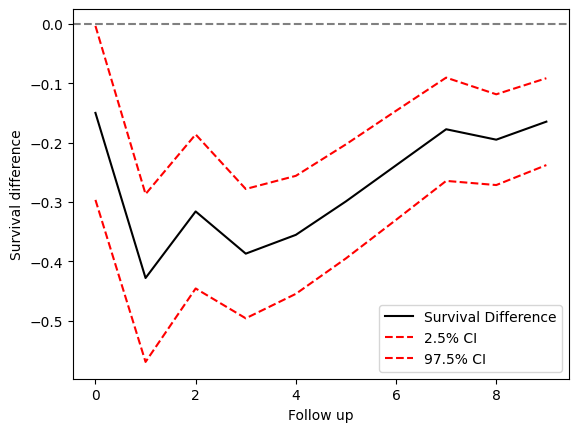

In [147]:
#predict and graph
predict_times = np.arange(0, 10)
trial.predict_survival_difference(predict_times)